*Colormap of the notebook:*

* <span style="color:red">assignment problem</span>. The red color indicates the task that should be done
* <span style="color:green">debugging</span>. The green tells you what is expected outcome. Its primarily goal to help you get the correct answer
* <span style="color:blue">hints</span>.

Assignment 4 (Convolutional Neural Network)
======================

partially based on 'PyTorch.ipynb' from assignment 2 in cs231 course.  
http://cs231n.github.io/assignments2017/assignment2/


PyTorch supports many layer types, loss functions, and optimizers

* Layers: http://pytorch.org/docs/nn.html
* Activations: http://pytorch.org/docs/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/optim.html#algorithms

##### Preliminaries

In [2]:
# for compatability issues 
from __future__ import print_function

In [3]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import copy

In [4]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable

In [5]:
# to make interactive plotting possible
%matplotlib inline
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [6]:
# make plots a bit nicer
plt.matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})

In [7]:
# random seed settings
torch.manual_seed(42)
np.random.seed(42)

# data type
dtype_np = np.float64
dtype_torch = torch.FloatTensor
dtype_torch_cuda = torch.cuda.FloatTensor # to run on GPU

#### Load the data

In [8]:
from src.data_set import DataSetCifar10, DataSetDTD

In [9]:
# do it for sanity check (that you have a dataset)
!./data/get_cifar10_dataset.sh # for cifar10
#!./data/get_dtd_dataset.sh # for dtd

/home/mykola/Documents/LvDSS2017/ComputerVision/LDSSS2017/assigments/data
file exists


In [10]:
path_data = 'data' 

* Hyper-parameters

In [11]:
batch_size=100
learning_rate = 1e-2

In [12]:
data_set = DataSetCifar10(path_data, num_dunkeys=4, batch_size=batch_size)
#data_set = DataSetDTD(path_data, num_dunkeys=4, batch_size=100, fin_scale=32)

#### Helper functions

In [2]:
def make_test(data_loader, model_current, train_test, gpu=False):
    """
     Giving dataset and model function calculates and prints out the accuracy
    
    Args:
        data_loader (DataLoader): loaded dataset
        model_current (model): the current model
        train_test (string): either 'train' or 'test' to define on which of these datasets we calculate accuracy
        gpu (bool): flag to indicate if our model runs on gpu
    """
    model.eval()
    correct = 0
    total = 0
    for images_, labels_ in data_loader[train_test]:
        
        if gpu:
            images_ = Variable(images_.type(dtype_torch_cuda), volatile=True)
            outputs_ = model_current(images_)
            _, predicted = torch.max(outputs_.data.cpu(), 1)
        else:
            images_ = Variable(images_)
            outputs_ = model_current(images_)
            _, predicted = torch.max(outputs_.data, 1)
            
        total += labels_.size(0)
        correct += (predicted == labels_).sum()
    print('accuracy[' + train_test + '] : %f %%' % (100 * correct / total))

Remember that our image data (and intermediate feature maps) are initially N x C x H x W, where:
* N is the number of datapoints
* C is the number of channels
* H is the height of the intermediate feature map in pixels
* W is the height of the intermediate feature map in pixels

we use a "Flatten" operation to collapse the C x H x W values per representation into a single long vector.

In [14]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

#### define model

In [15]:
# Here's where we define the architecture of the model... 
first_model = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                Flatten(), # see above for explanation
                nn.Linear(5408, 10), # affine layer
              )

# Set the type of all data in this model to be FloatTensor 
first_model.type(dtype_torch)

Sequential (
  (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2))
  (1): ReLU (inplace)
  (2): Flatten (
  )
  (3): Linear (5408 -> 10)
)

In [16]:
model = copy.deepcopy(first_model).type(dtype_torch)

* Loss function

In [17]:
criterion = nn.CrossEntropyLoss().type(dtype_torch)

* define optimizer

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

* train the model

In [19]:
num_epochs = 1

In [20]:
# train
t = 0
logger = {}
logger['iteration'] = []
logger['loss_iteration'] = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_set.loader['train']):
        # get data to train
        images = Variable(images.type(dtype_torch))
        labels = Variable(labels.type(dtype_torch).long())

        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model.forward(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # reporting & logging
        logger['iteration'] += [t]
        logger['loss_iteration'] += [loss.data[0]]
        t += 1
        if t % 100 == 0:
            print('epoch: [%d/%d], step: [%d/%d], loss: %.4f' %
                   (epoch + 1, num_epochs, i+1, len(data_set.dataset['train'])//batch_size, loss.data[0]))
        
    print('--- epoch: [%d, %d]' % (epoch + 1, num_epochs))
    #make_test(data_set.loader, model, 'train')
    make_test(data_set.loader, model, 'test')

    # switch back to the training  mode
    model.train()

epoch: [1/1], step: [100/500], loss: 1.8933
epoch: [1/1], step: [200/500], loss: 1.5111
epoch: [1/1], step: [300/500], loss: 1.4503
epoch: [1/1], step: [400/500], loss: 1.5622
epoch: [1/1], step: [500/500], loss: 1.5233
--- epoch: [1, 1]
accuracy[test] : 47.270000 %


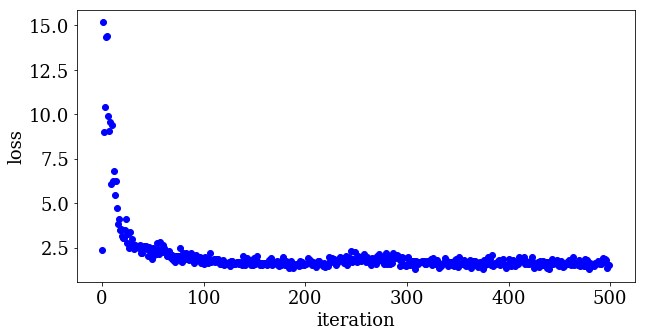

In [21]:
# visualize loss
plt.figure(figsize=(10,5))
plt.plot(logger['iteration'], logger['loss_iteration'],'ob', label="loss")

plt.xlabel('iteration')
plt.ylabel('loss');

#### Run model on GPU

In [21]:
# Verify that CUDA is properly configured and you have a GPU available
torch.cuda.is_available()

True

In [22]:
model_gpu = copy.deepcopy(model).type(dtype_torch_cuda)

In [23]:
# variable for CPU ( as usual )
x = torch.randn(128, 3, 32, 32).type(dtype_torch)
x_var = Variable(x.type(dtype_torch)) # Construct a PyTorch Variable out of your input data

# and now for GPU
x_gpu = torch.randn(128, 3, 32, 32).type(dtype_torch_cuda)
x_var_gpu = Variable(x.type(dtype_torch_cuda)) # Construct a PyTorch Variable out of your input data

In [24]:
%%timeit 
yyy = model(x_var)

100 loops, best of 3: 6.49 ms per loop


In [25]:
%%timeit 
torch.cuda.synchronize() # make sure there are no pending GPU computations
yyy = model_gpu(x_var_gpu) 
torch.cuda.synchronize() # make sure there are no pending GPU computations

The slowest run took 416.86 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 1.46 ms per loop


In [26]:
num_epochs = 10

In [27]:
criterion_gpu = nn.CrossEntropyLoss().type(dtype_torch_cuda)
optimizer_gpu = torch.optim.Adam(model_gpu.parameters(), lr=learning_rate)

In [28]:
# train gpu model
t = 0
logger = {}
logger['iteration'] = []
logger['loss_iteration'] = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_set.loader['train']):
        # get data to train
        images = Variable(images.type(dtype_torch_cuda))
        labels = Variable(labels.type(dtype_torch_cuda).long())

        # forward + backward + optimize
        optimizer_gpu.zero_grad()
        outputs = model_gpu.forward(images)
        loss = criterion_gpu(outputs, labels)
        loss.backward()
        optimizer_gpu.step()

        # reporting & logging
        logger['iteration'] += [t]
        logger['loss_iteration'] += [loss.data[0]]
        t += 1
        if t % 100 == 0:
            print('epoch: [%d/%d], step: [%d/%d], loss: %.4f' %
                   (epoch + 1, num_epochs, i+1, len(data_set.dataset['train'])//batch_size, loss.data[0]))
        
    print('--- epoch: [%d, %d]' % (epoch + 1, num_epochs))
    #make_test(data_set.loader, model_gpu, 'train')
    make_test(data_set.loader, model_gpu, 'test', gpu=True)

    # switch back to the training  mode
    model_gpu.train()

epoch: [1/10], step: [100/500], loss: 10661.1104
epoch: [1/10], step: [200/500], loss: 37117.7773
epoch: [1/10], step: [300/500], loss: 64515.1016
epoch: [1/10], step: [400/500], loss: 131198.7656
epoch: [1/10], step: [500/500], loss: 185517.4531
--- epoch: [1, 10]
accuracy[test] : 14.540000 %
epoch: [2/10], step: [100/500], loss: 327276.4688
epoch: [2/10], step: [200/500], loss: 253440.9531
epoch: [2/10], step: [300/500], loss: 314021.1875
epoch: [2/10], step: [400/500], loss: 275305.3750
epoch: [2/10], step: [500/500], loss: 441624.2500
--- epoch: [2, 10]
accuracy[test] : 17.030000 %
epoch: [3/10], step: [100/500], loss: 377274.1875
epoch: [3/10], step: [200/500], loss: 244484.3594
epoch: [3/10], step: [300/500], loss: 382759.9062
epoch: [3/10], step: [400/500], loss: 491383.5938
epoch: [3/10], step: [500/500], loss: 411129.1562
--- epoch: [3, 10]
accuracy[test] : 22.190000 %
epoch: [4/10], step: [100/500], loss: 707571.3750
epoch: [4/10], step: [200/500], loss: 511280.5312
epoch: [4

<span style="color:red"> **[PROBLEM]**: </span>  
<span style="color:red"> Using the code provided above as guidance, </span>  
<span style="color:red"> and using the following PyTorch documentation, specify a model with the following architecture: </span>  

<span style="color:red"> - 7x7 Convolutional Layer with 32 filters and stride of 1 </span>  
<span style="color:red"> - ReLU Activation Layer </span>  
<span style="color:red"> - BatchNorm2D (spatial batch normalization) </span>  
<span style="color:red"> - 2x2 Max Pooling layer with a stride of 2 </span>  
<span style="color:red"> - Affine layer with 1024 output units </span>  
<span style="color:red"> - ReLU Activation Layer </span>  
<span style="color:red"> - Affine layer from 1024 input units to 10 outputs </span>  
<span style="color:red"> - And finally, set up a **cross-entropy** loss function and the **RMSprop** learning rule. </span>  

<span style="color:blue"> To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes): </span>  

In [ ]:
new_model = nn.Sequential( # You fill this in!
                         )

model_gpu = copy.deepcopy(new_model).type(dtype_torch_cuda)

In [ ]:
x = torch.randn(64, 3, 32, 32).type(dtype_torch_cuda)
x_var = Variable(x.type(dtype_torch_cuda)) 
ans = model_gpu(x_var)        

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([64, 10])) 

## Tips from *cs231 course*

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use Dropout.

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. 

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)
